# Locating a Coffee Shop in Toronto

## Part 0 - Preparation

In [256]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

In [257]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
 
# libraries for displaying images
from IPython.display import Image
from IPython.core.display import HTML
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize
 
!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
 
print('Folium installed')
print('Libraries imported.')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Folium installed
Libraries imported.


## Part 1 - Get Postal Code Data

Import latitude and longitude from separate CSV file

In [260]:
lat_long_df = pd.read_csv('https://cocl.us/Geospatial_data')
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [261]:
lat_long_df.shape

(103, 3)

## Part 2 - Find Bars and Coffee Shops

In [262]:
#Establish constants we will use for the FourSquare API
CLIENT_ID = 'GYLX2FKS50CNPV3PDRHAUGMY4P3GOKKEKBB5KW4FFJERCXRG' # Foursquare ID
CLIENT_SECRET = 'IU4AQLTCE3CIBP2Z2IOIXZU4LDZGJCGC0PXQIUOAZYXEMOWU' # Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [340]:
#Find coffee shops near each postal code centroid and place into venues_df
coffee_search_query = 'Coffee'
bar_search_query = 'Bar'

radius = 2000
coffee_shops_venues = []
coffee_shops_count = []
bars_venues = []
bars_count = []

for i in range(0,len(lat_long_df)): 
    if i%10==0:
        print(f"Now starting row: {i+1} of {len(lat_long_df)} = {100*(i+1)/len(lat_long_df)}% complete.")
    latitude = lat_long_df.loc[i,'Latitude']
    longitude = lat_long_df.loc[i,'Longitude']

    url = f"https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={latitude},{longitude}&v={VERSION}&query={coffee_search_query}&radius={radius}&limit={LIMIT}"
    results = requests.get(url).json()
    coffee_shops_venues.append(results['response']['venues'])
    coffee_shops_count.append(len(results['response']['venues']))

    url = f"https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={latitude},{longitude}&v={VERSION}&query={bar_search_query}&radius={radius}&limit={LIMIT}"
    results = requests.get(url).json()
    bars_venues.append(results['response']['venues'])
    bars_count.append(len(results['response']['venues']))

Now starting row: 1 of 103 = 0.970873786407767% complete.
Now starting row: 11 of 103 = 10.679611650485437% complete.
Now starting row: 21 of 103 = 20.388349514563107% complete.
Now starting row: 31 of 103 = 30.097087378640776% complete.
Now starting row: 41 of 103 = 39.80582524271845% complete.
Now starting row: 51 of 103 = 49.51456310679612% complete.
Now starting row: 61 of 103 = 59.22330097087379% complete.
Now starting row: 71 of 103 = 68.93203883495146% complete.
Now starting row: 81 of 103 = 78.64077669902913% complete.
Now starting row: 91 of 103 = 88.3495145631068% complete.
Now starting row: 101 of 103 = 98.05825242718447% complete.


In [264]:
temp_ls = list(zip(lat_long_df['Postal Code'], lat_long_df['Latitude'], lat_long_df['Longitude'],coffee_shops_venues, coffee_shops_count, bars_venues, bars_count))
venues_df = pd.DataFrame(temp_ls, columns = ['Postal Code', 'Latitude', 'Longitude', 'Coffee Shop Venues', 'Coffee Shop Count', 'Bars Venues','Bars Count'])
print("Dataframe Generation Complete")

Dataframe Generation Complete


In [269]:
#Calculate the ratio of bars to coffee shops
venues_df['Ratio'] = venues_df['Bars Count']/venues_df['Coffee Shop Count'] * 100

In [268]:
#Find the postal code with highest ratio of bars to coffee shops
venues_df.sort_values(by=['Ratio','Coffee Shop Count'], inplace=True, ascending=False)
venues_df.head()

,Postal Code,Latitude,Longitude,Coffee Shop Venues,Coffee Shop Count,Bars Venues,Bars Count,Ratio
16,M1X,43.836125,-79.205636,[],0,"[{'id': '4db5ac9d1e7248d135b982e6', 'name': 'G...",1,inf
6,M1K,43.727929,-79.262029,"[{'id': '4f85761ee4b0388157a38e95', 'name': 'C...",1,"[{'id': '4b7c9ea1f964a520219e2fe3', 'name': 'S...",24,2400.0
97,M9M,43.724766,-79.532242,"[{'id': '4d1c614409546dcb117ad138', 'name': 'C...",1,"[{'id': '4f80b6ece4b09a1477130e6d', 'name': 'W...",21,2100.0
62,M5M,43.733283,-79.419750,"[{'id': '50a81655e4b0e7faf55ff531', 'name': 'W...",2,"[{'id': '4d02475137caa1cd3c56e347', 'name': 'J...",30,1500.0
8,M1M,43.716316,-79.239476,"[{'id': '4f85761ee4b0388157a38e95', 'name': 'C...",1,"[{'id': '4e0a7b3a1f6e56a68103934a', 'name': 'A...",14,1400.0


## Part 3 - Visualize the Data Sets

In [324]:
m1k_coffee_shops = venues_df.loc[6,'Coffee Shop Venues']
m1k_coffee_shop_count = venues_df.loc[6,'Coffee Shop Count']
m1k_bars = venues_df.loc[6,'Bars Venues']
m1k_bars_count = venues_df.loc[6,'Bars Count']

In [334]:
m9m_coffee_shops = venues_df.loc[97,'Coffee Shop Venues']
m9m_coffee_shop_count = venues_df.loc[97,'Coffee Shop Count']
m9m_bars = venues_df.loc[97,'Bars Venues']
m9m_bars_count = venues_df.loc[97,'Bars Count']

In [341]:
m1k_venues_map = folium.Map(location=[venues_df.loc[6,'Latitude'], venues_df.loc[6,'Longitude']], zoom_start=12)

In [330]:
# add M1K Coffee Shops as Red Circles
for i in range(0,m1k_coffee_shop_count):
    #print(f"Adding Coffee Shop {i}")
    location = m1k_coffee_shops[i].get('location')
    latitude = location.get('lat')
    longitude = location.get('lng')
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=10,
        popup=m1k_coffee_shops[i].get('name'),
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
        ).add_to(m1k_venues_map)
m1k_venues_map

In [332]:
# add M1K Bars as Blue Circles
for i in range(0,m1k_bars_count):
    #print(f"Adding Bar {i}")
    location = m1k_bars[i].get('location')
    latitude = location.get('lat')
    longitude = location.get('lng')
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=10,
        popup=m1k_bars[i].get('name'),
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(m1k_venues_map)   
m1k_venues_map

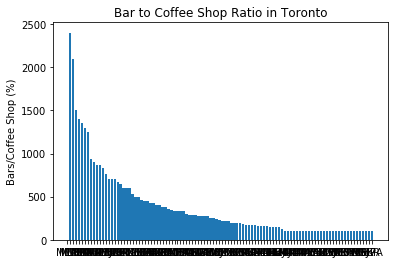

In [320]:
import matplotlib.pyplot as plt

y_pos = np.arange(len(venues_df['Postal Code']))

plt.bar(y_pos, venues_df['Ratio'], align='center', alpha=1)
plt.xticks(y_pos, venues_df['Postal Code'])
plt.ylabel('Bars/Coffee Shop (%)')
plt.title('Bar to Coffee Shop Ratio in Toronto')

plt.show()

In [342]:
# generate map for M9m
m9m_venues_map = folium.Map(location=[venues_df.loc[97,'Latitude'], venues_df.loc[97,'Longitude']], zoom_start=12)    

In [338]:
# add Coffee Shops as Red Circles
for i in range(0,m9m_coffee_shop_count):
    #print(f"Adding Coffee Shop {i}")
    location = m9m_coffee_shops[i].get('location')
    latitude = location.get('lat')
    longitude = location.get('lng')
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=10,
        popup=m9m_coffee_shops[i].get('name'),
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.6
        ).add_to(m9m_venues_map)
m9m_venues_map

In [339]:
# add Bars as Blue Circles
for i in range(0,m9m_bars_count):
    #print(f"Adding Bar {i}")
    location = m9m_bars[i].get('location')
    latitude = location.get('lat')
    longitude = location.get('lng')
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=10,
        popup=m9m_bars[i].get('name'),
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(m9m_venues_map)    
m9m_venues_map

## Part 4 - Check Coffee Shop Ratings for M1K

In [273]:
postal_code_venue_df = pd.DataFrame(venues_df.loc[6,'Coffee Shop Venues'])
postal_code_venue_df

,id,name,location,categories,referralId,hasPerk
0,4f85761ee4b0388157a38e95,Coffee Break,"{'lat': 43.70406651209047, 'lng': -79.25227035...","[{'id': '4bf58dd8d48988d148941735', 'name': 'D...",v-1586077451,False


In [274]:
venue_id = postal_code_venue_df.iloc[0]['id']
url = f"https://api.foursquare.com/v2/venues/{venue_id}?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}"
results = requests.get(url).json()
venue_details = results['response']
venue_details_df = pd.json_normalize(venue_details)
venue_details_df

4f85761ee4b0388157a38e95


,venue.id,venue.name,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.cc,venue.location.country,venue.location.formattedAddress,venue.canonicalUrl,venue.categories,...,venue.shortUrl,venue.timeZone,venue.listed.count,venue.listed.groups,venue.seasonalHours,venue.pageUpdates.count,venue.pageUpdates.items,venue.inbox.count,venue.inbox.items,venue.attributes.groups
0,4f85761ee4b0388157a38e95,Coffee Break,43.704067,-79.25227,"[{'label': 'display', 'lat': 43.70406651209047...",CA,Canada,[Canada],https://foursquare.com/v/coffee-break/4f85761e...,"[{'id': '4bf58dd8d48988d148941735', 'name': 'D...",...,http://4sq.com/Isr42D,America/Toronto,0,"[{'type': 'others', 'name': 'Lists from other ...",[],0,[],0,[],"[{'type': 'price', 'name': 'Price', 'summary':..."


In [275]:
venue_details_df.columns

Index(['venue.id', 'venue.name', 'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.cc',
       'venue.location.country', 'venue.location.formattedAddress',
       'venue.canonicalUrl', 'venue.categories', 'venue.verified',
       'venue.stats.tipCount', 'venue.price.tier', 'venue.price.message',
       'venue.price.currency', 'venue.likes.count', 'venue.likes.groups',
       'venue.dislike', 'venue.ok', 'venue.allowMenuUrlEdit',
       'venue.beenHere.count', 'venue.beenHere.unconfirmedCount',
       'venue.beenHere.marked', 'venue.beenHere.lastCheckinExpiredAt',
       'venue.specials.count', 'venue.specials.items', 'venue.photos.count',
       'venue.photos.groups', 'venue.reasons.count', 'venue.reasons.items',
       'venue.hereNow.count', 'venue.hereNow.summary', 'venue.hereNow.groups',
       'venue.createdAt', 'venue.tips.count', 'venue.tips.groups',
       'venue.shortUrl', 'venue.timeZone', 'venue.listed.count',
       'venue.li

## Part 5 - Check Coffee Shop Ratings for M9M

In [276]:
postal_code_venue_2_df = pd.DataFrame(venues_df.loc[97,'Coffee Shop Venues'])
postal_code_venue_2_df

,id,name,location,categories,referralId,hasPerk
0,4d1c614409546dcb117ad138,Coffee time,"{'crossStreet': 'Jane st', 'lat': 43.721045063...",[],v-1586078007,False


In [278]:
venue_id_2 = postal_code_venue_2_df.iloc[0]['id']
url = f"https://api.foursquare.com/v2/venues/{venue_id_2}?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}"
results_2 = requests.get(url).json()
venue_details_2 = results_2['response']
venue_details_2_df = pd.json_normalize(venue_details_2)
venue_details_2_df

,venue.id,venue.name,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,...,venue.shortUrl,venue.timeZone,venue.listed.count,venue.listed.groups,venue.seasonalHours,venue.pageUpdates.count,venue.pageUpdates.items,venue.inbox.count,venue.inbox.items,venue.attributes.groups
0,4d1c614409546dcb117ad138,Coffee time,Jane st,43.721045,-79.508923,"[{'label': 'display', 'lat': 43.72104506370656...",CA,Toronto,ON,Canada,...,http://4sq.com/hJARHT,America/Toronto,0,"[{'type': 'others', 'name': 'Lists from other ...",[],0,[],0,[],[]


In [279]:
venue_details_df.columns

Index(['venue.id', 'venue.name', 'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.cc',
       'venue.location.country', 'venue.location.formattedAddress',
       'venue.canonicalUrl', 'venue.categories', 'venue.verified',
       'venue.stats.tipCount', 'venue.price.tier', 'venue.price.message',
       'venue.price.currency', 'venue.likes.count', 'venue.likes.groups',
       'venue.dislike', 'venue.ok', 'venue.allowMenuUrlEdit',
       'venue.beenHere.count', 'venue.beenHere.unconfirmedCount',
       'venue.beenHere.marked', 'venue.beenHere.lastCheckinExpiredAt',
       'venue.specials.count', 'venue.specials.items', 'venue.photos.count',
       'venue.photos.groups', 'venue.reasons.count', 'venue.reasons.items',
       'venue.hereNow.count', 'venue.hereNow.summary', 'venue.hereNow.groups',
       'venue.createdAt', 'venue.tips.count', 'venue.tips.groups',
       'venue.shortUrl', 'venue.timeZone', 'venue.listed.count',
       'venue.li